In [21]:
import pandas as pd

# load devnagari data
df = pd.read_csv("data/maibert_dataset.csv", encoding='utf-8')

df.head()

,text,labels,text_length,word_count,sentence_count
0,शीतलं निर्मलं तोयं कर्पूरेण सुवासितम्। आचम्यता...,Culture,163,24,4
1,देश भरि मे मंदिर के संख्या कतेक अछि ई सवाल आर्...,Entertainment,270,54,3
2,सो काल-खण्डमा कलम चलाउने कारीगरहरुले मातृशक्ति...,Culture,244,35,2
3,सिनेमाक निर्माण करबाक अछि।काठमांडू के मोएक्स ह...,Entertainment,812,142,6
4,मंगलवार क॑ राजधानी डुप्लीकेट ईस्ट वेस्ट कॉन्टा...,EduTech,2220,412,16


In [22]:
# Data exploration
print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['labels'].value_counts())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (12383, 5)

Label distribution:
labels
Culture          2575
Literature       2212
Politics         2075
Sports           1774
Entertainment     844
Opinion           805
EduTech           619
Economy           549
Health            506
Interview         424
Name: count, dtype: int64

Basic statistics:
        text_length    word_count  sentence_count
count  12383.000000  12383.000000    12383.000000
mean     872.772591    158.615844        9.535654
std      876.017370    158.986193        9.475171
min        0.000000      1.000000        1.000000
25%      225.000000     38.000000        3.000000
50%      456.000000     86.000000        6.000000
75%     1265.000000    230.500000       13.000000
max     5277.000000    512.000000       86.000000


In [23]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Prepare the data
X = df['text']
y = df['labels']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Label encoding:
Culture: 0
Economy: 1
EduTech: 2
Entertainment: 3
Health: 4
Interview: 5
Literature: 6
Opinion: 7
Politics: 8
Sports: 9

Training set size: 9906
Test set size: 2477


In [25]:
# drop nan and reset index
df = df.dropna().reset_index(drop=True)

In [26]:
# print nan values
print(df.isnull().sum())

text              0
labels            0
text_length       0
word_count        0
sentence_count    0
dtype: int64


In [28]:
# Re-create train/test split after dropping NaN values
X = df['text']
y = df['labels']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding after cleaning:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nCleaned training set size: {len(X_train)}")
print(f"Cleaned test set size: {len(X_test)}")

# Check for any remaining NaN values
print(f"\nNaN values in X_train: {X_train.isnull().sum()}")
print(f"NaN values in X_test: {X_test.isnull().sum()}")

Label encoding after cleaning:
Culture: 0
Economy: 1
EduTech: 2
Entertainment: 3
Health: 4
Interview: 5
Literature: 6
Opinion: 7
Politics: 8
Sports: 9

Cleaned training set size: 9900
Cleaned test set size: 2476

NaN values in X_train: 0
NaN values in X_test: 0


In [29]:
# TF-IDF Vectorization
print("Applying TF-IDF vectorization...")

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.8,  # Ignore terms that appear in more than 80% of documents
    stop_words=None,  # Keep all words since this is multilingual text
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"Sparsity: {(1.0 - X_train_tfidf.nnz / float(X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

Applying TF-IDF vectorization...
TF-IDF matrix shape: (9900, 5000)
Number of features: 5000
Sparsity: 98.45%


In [30]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print('='*50)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Classification report
    print("\nClassification Report:")
    target_names = label_encoder.classes_
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, cv_scores.mean()

In [31]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Store results
results = {}

print("Starting model evaluation...")


Starting model evaluation...



Evaluating Logistic Regression
Accuracy: 0.7492
Cross-validation accuracy: 0.7371 (+/- 0.0061)

Classification Report:
               precision    recall  f1-score   support

      Culture       0.72      0.78      0.75       515
      Economy       0.84      0.78      0.81       110
      EduTech       0.78      0.25      0.38       124
Entertainment       0.73      0.60      0.66       169
       Health       0.88      0.37      0.52       101
    Interview       0.86      0.69      0.77        85
   Literature       0.66      0.80      0.73       441
      Opinion       0.86      0.63      0.73       161
     Politics       0.76      0.91      0.83       415
       Sports       0.81      0.85      0.83       355

     accuracy                           0.75      2476
    macro avg       0.79      0.67      0.70      2476
 weighted avg       0.76      0.75      0.74      2476



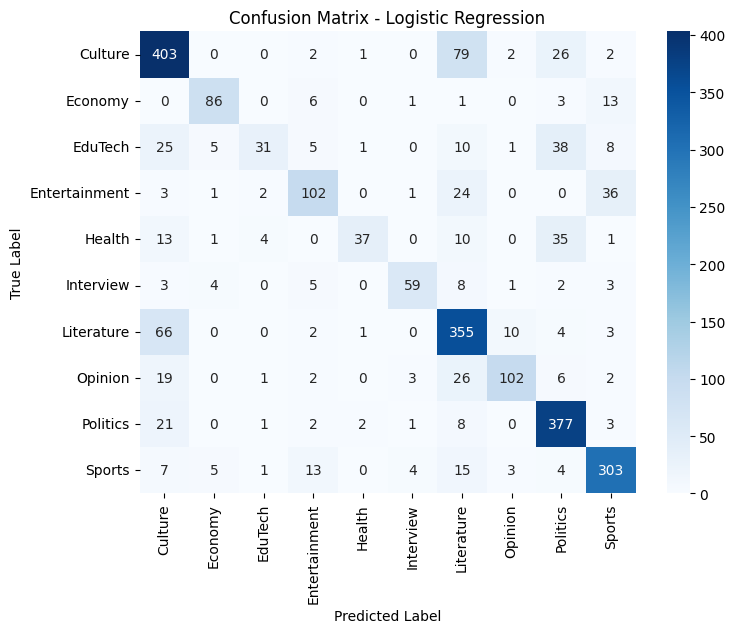


Evaluating SVM (Linear)
Accuracy: 0.7670
Cross-validation accuracy: 0.7563 (+/- 0.0152)

Classification Report:
               precision    recall  f1-score   support

      Culture       0.73      0.76      0.74       515
      Economy       0.83      0.81      0.82       110
      EduTech       0.66      0.33      0.44       124
Entertainment       0.78      0.66      0.71       169
       Health       0.77      0.48      0.59       101
    Interview       0.90      0.72      0.80        85
   Literature       0.68      0.80      0.74       441
      Opinion       0.79      0.71      0.75       161
     Politics       0.81      0.91      0.86       415
       Sports       0.83      0.89      0.86       355

     accuracy                           0.77      2476
    macro avg       0.78      0.71      0.73      2476
 weighted avg       0.77      0.77      0.76      2476



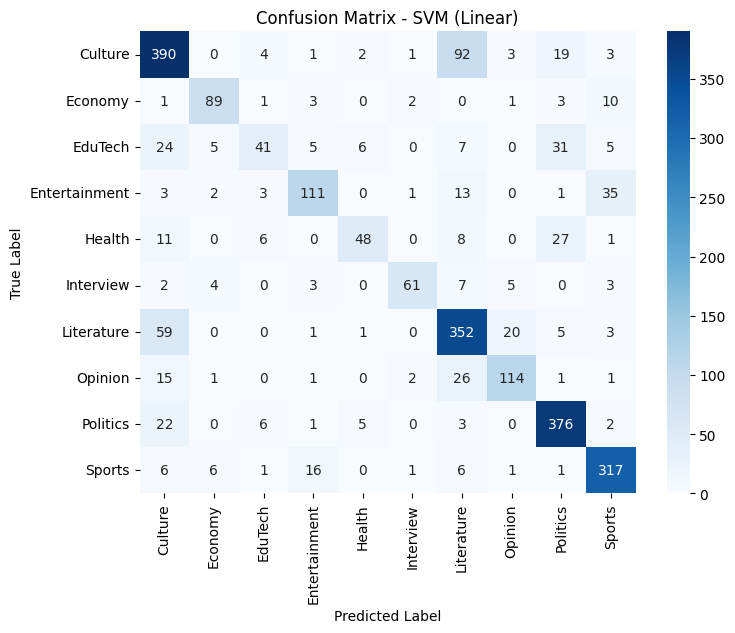


Evaluating SVM (RBF)
Accuracy: 0.7573
Cross-validation accuracy: 0.7465 (+/- 0.0075)

Classification Report:
               precision    recall  f1-score   support

      Culture       0.73      0.76      0.74       515
      Economy       0.87      0.82      0.84       110
      EduTech       0.77      0.19      0.31       124
Entertainment       0.80      0.60      0.69       169
       Health       0.88      0.36      0.51       101
    Interview       0.90      0.66      0.76        85
   Literature       0.66      0.84      0.74       441
      Opinion       0.85      0.65      0.74       161
     Politics       0.76      0.92      0.83       415
       Sports       0.82      0.90      0.86       355

     accuracy                           0.76      2476
    macro avg       0.80      0.67      0.70      2476
 weighted avg       0.77      0.76      0.74      2476



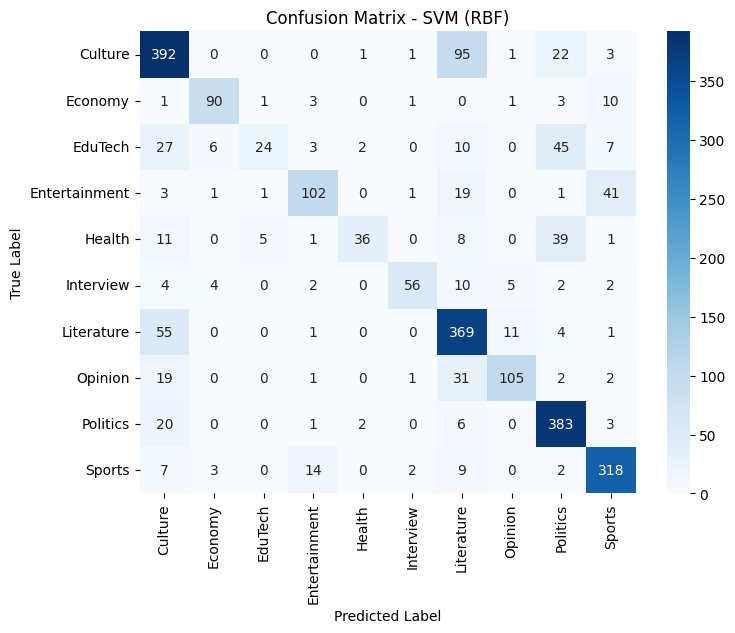


Evaluating K-Nearest Neighbors
Accuracy: 0.2112
Cross-validation accuracy: 0.1915 (+/- 0.0348)

Classification Report:
               precision    recall  f1-score   support

      Culture       0.83      0.10      0.17       515
      Economy       0.11      0.29      0.16       110
      EduTech       0.07      0.52      0.12       124
Entertainment       0.75      0.05      0.10       169
       Health       0.87      0.20      0.32       101
    Interview       0.11      0.38      0.17        85
   Literature       0.85      0.05      0.09       441
      Opinion       0.92      0.27      0.42       161
     Politics       0.29      0.51      0.37       415
       Sports       0.98      0.11      0.20       355

     accuracy                           0.21      2476
    macro avg       0.58      0.25      0.21      2476
 weighted avg       0.67      0.21      0.21      2476



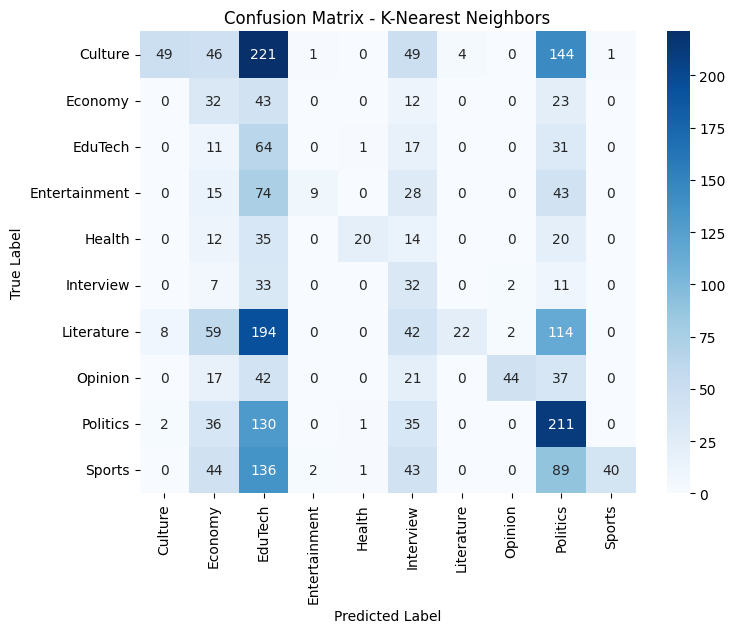


Evaluating Random Forest
Accuracy: 0.6563
Cross-validation accuracy: 0.6483 (+/- 0.0083)

Classification Report:
               precision    recall  f1-score   support

      Culture       0.68      0.70      0.69       515
      Economy       0.76      0.56      0.65       110
      EduTech       0.21      0.03      0.06       124
Entertainment       0.85      0.28      0.42       169
       Health       0.69      0.11      0.19       101
    Interview       0.98      0.54      0.70        85
   Literature       0.55      0.80      0.65       441
      Opinion       0.89      0.32      0.47       161
     Politics       0.65      0.90      0.75       415
       Sports       0.70      0.90      0.78       355

     accuracy                           0.66      2476
    macro avg       0.70      0.51      0.54      2476
 weighted avg       0.67      0.66      0.62      2476



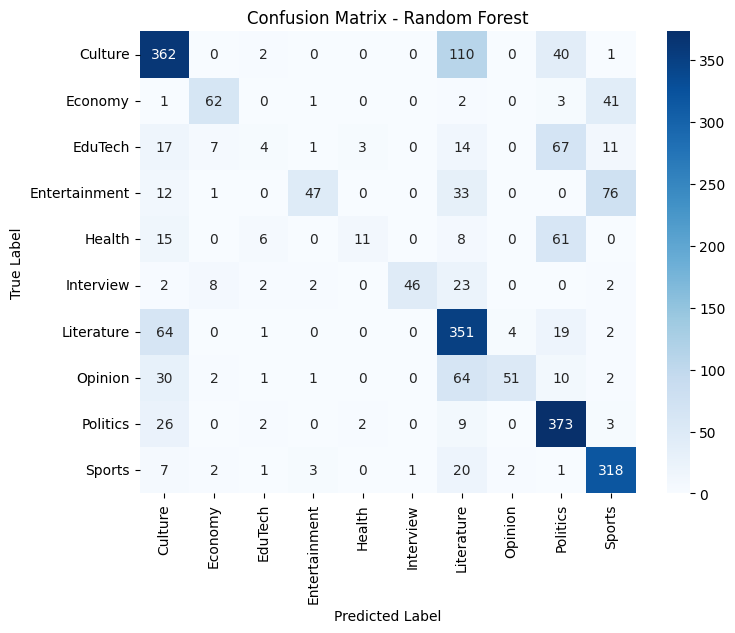


Evaluating Naive Bayes
Accuracy: 0.6458
Cross-validation accuracy: 0.6334 (+/- 0.0067)

Classification Report:
               precision    recall  f1-score   support

      Culture       0.58      0.79      0.67       515
      Economy       0.91      0.37      0.53       110
      EduTech       1.00      0.01      0.02       124
Entertainment       0.79      0.30      0.43       169
       Health       1.00      0.02      0.04       101
    Interview       1.00      0.28      0.44        85
   Literature       0.59      0.79      0.68       441
      Opinion       0.89      0.26      0.40       161
     Politics       0.72      0.88      0.79       415
       Sports       0.66      0.89      0.76       355

     accuracy                           0.65      2476
    macro avg       0.81      0.46      0.47      2476
 weighted avg       0.72      0.65      0.60      2476



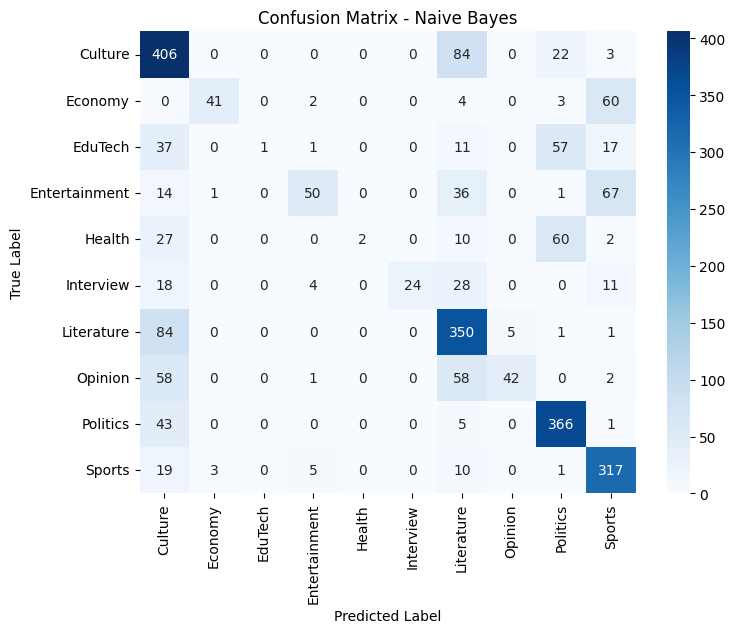

In [32]:
# Evaluate all models
for model_name, model in models.items():
    try:
        accuracy, cv_accuracy = evaluate_model(
            model, X_train_tfidf, X_test_tfidf, y_train, y_test, model_name
        )
        results[model_name] = {
            'accuracy': accuracy,
            'cv_accuracy': cv_accuracy
        }
    except Exception as e:
        print(f"Error with {model_name}: {e}")
        continue



MODEL COMPARISON SUMMARY
                     accuracy  cv_accuracy
SVM (Linear)         0.766963     0.756263
SVM (RBF)            0.757270     0.746465
Logistic Regression  0.749192     0.737071
Random Forest        0.656300     0.648283
Naive Bayes          0.645800     0.633434
K-Nearest Neighbors  0.211228     0.191515


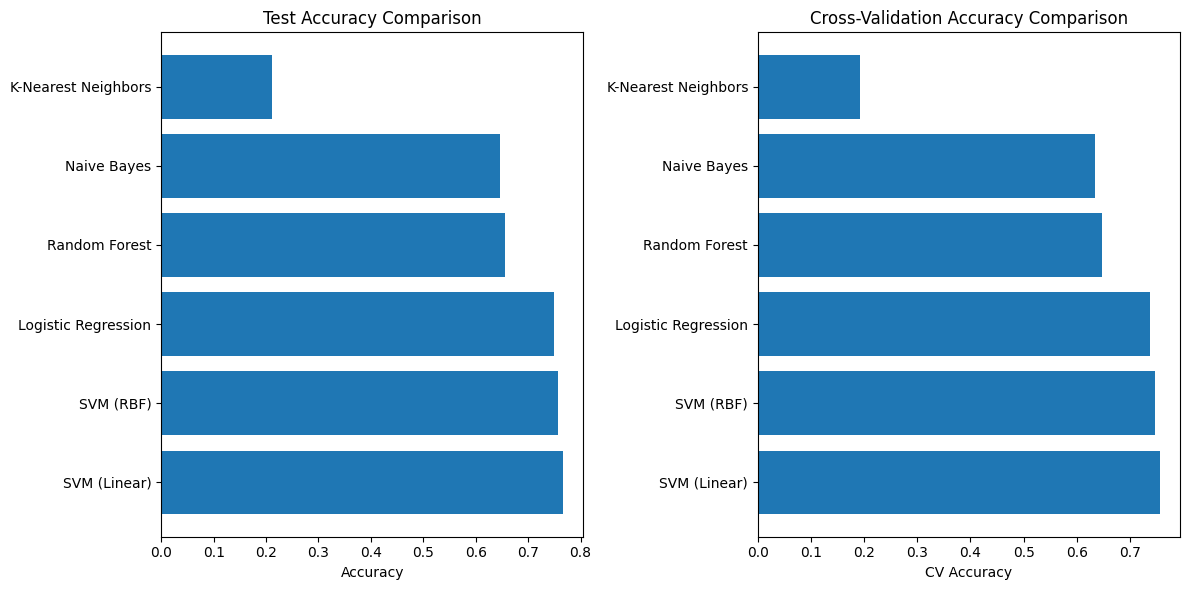


Best performing model: SVM (Linear) with accuracy: 0.7670


In [33]:
# Compare model performance
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy', ascending=False)
print(results_df)

# Visualize model comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(results_df.index, results_df['accuracy'])
plt.title('Test Accuracy Comparison')
plt.xlabel('Accuracy')

plt.subplot(1, 2, 2)
plt.barh(results_df.index, results_df['cv_accuracy'])
plt.title('Cross-Validation Accuracy Comparison')
plt.xlabel('CV Accuracy')

plt.tight_layout()
plt.show()

print(f"\nBest performing model: {results_df.index[0]} with accuracy: {results_df.iloc[0]['accuracy']:.4f}")



CLUSTERING ANALYSIS
Clusters: 2, Inertia: 9249.83, Silhouette Score: 0.0091
Clusters: 3, Inertia: 9160.09, Silhouette Score: 0.0098
Clusters: 4, Inertia: 9099.33, Silhouette Score: 0.0106
Clusters: 5, Inertia: 9056.23, Silhouette Score: 0.0111
Clusters: 6, Inertia: 9013.90, Silhouette Score: 0.0058
Clusters: 7, Inertia: 8978.81, Silhouette Score: 0.0066


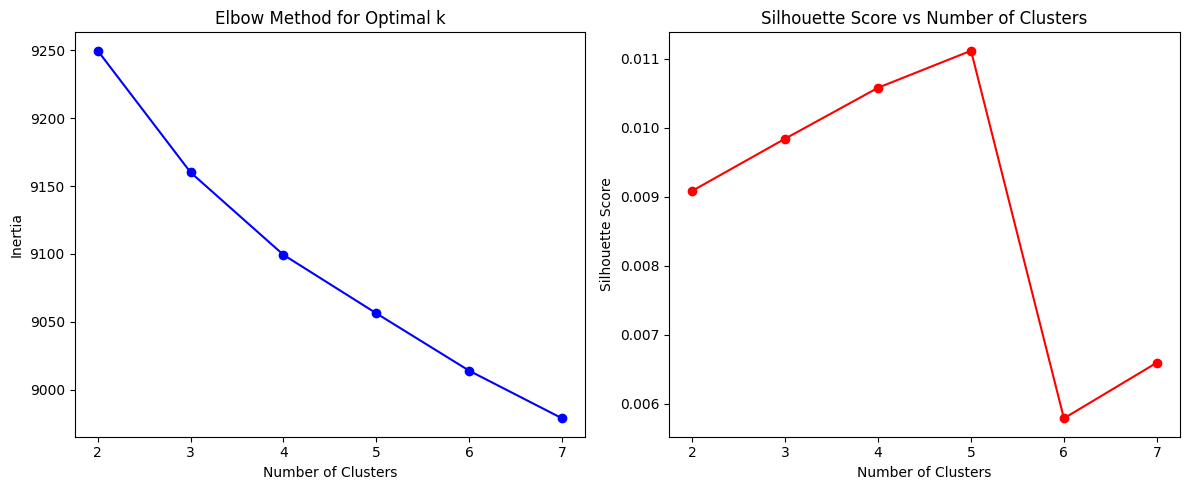

In [34]:
# CLUSTERING ANALYSIS
print("\n" + "="*60)
print("CLUSTERING ANALYSIS")
print("="*60)

# Determine optimal number of clusters using elbow method
from sklearn.metrics import silhouette_score

# Test different number of clusters
n_clusters_range = range(2, 8)
inertias = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_tfidf)
    
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_train_tfidf, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"Clusters: {n_clusters}, Inertia: {kmeans.inertia_:.2f}, Silhouette Score: {silhouette_avg:.4f}")

# Plot elbow curve and silhouette scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, inertias, 'bo-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, silhouette_scores, 'ro-')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



Performing K-Means clustering with 10 clusters...
Adjusted Rand Index: 0.1449
Normalized Mutual Information: 0.2962

Reducing dimensions for visualization...


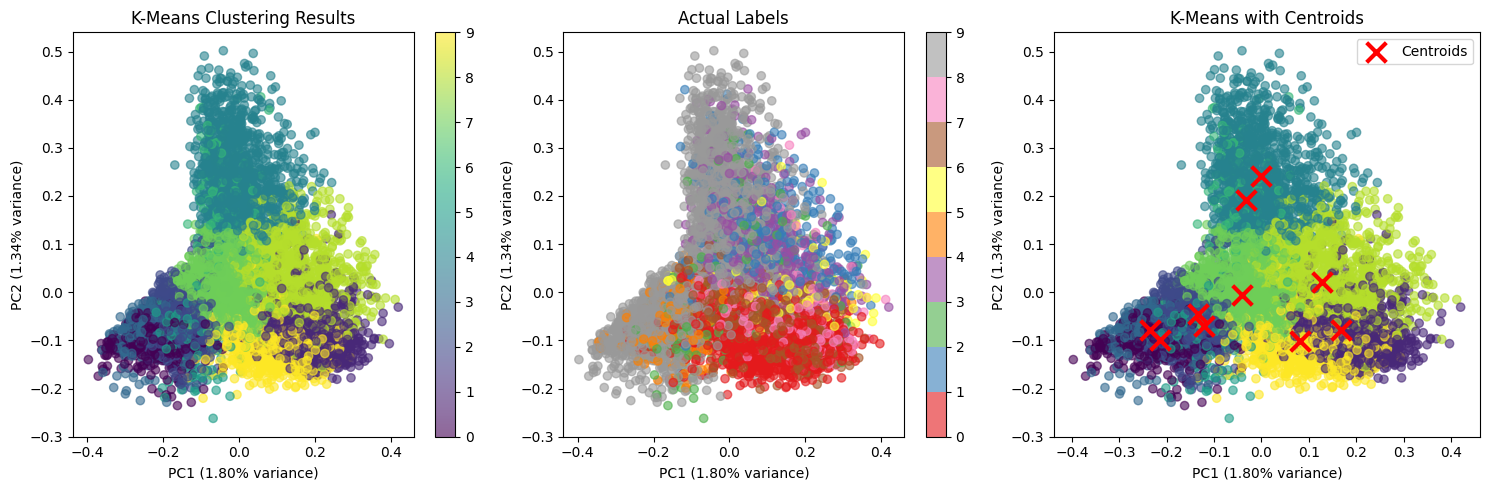


PCA Explained Variance Ratio: [0.01801073 0.01342084]
Total Explained Variance: 0.0314


In [35]:
# Perform clustering with optimal number of clusters (let's use 3 based on the labels we have)
optimal_clusters = len(label_encoder.classes_)
print(f"\nPerforming K-Means clustering with {optimal_clusters} clusters...")

kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_train_tfidf)

# Compare clustering results with actual labels
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_train, cluster_labels)
nmi = normalized_mutual_info_score(y_train, cluster_labels)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

# Visualize clusters using PCA
print("\nReducing dimensions for visualization...")
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(15, 5))

# Plot clusters
plt.subplot(1, 3, 1)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering Results')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter)

# Plot actual labels
plt.subplot(1, 3, 2)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='Set1', alpha=0.6)
plt.title('Actual Labels')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter)

# Plot cluster centers
plt.subplot(1, 3, 3)
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.title('K-Means with Centroids')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance: {pca.explained_variance_ratio_.sum():.4f}")


In [37]:
# HYPERPARAMETER TUNING FOR BEST MODEL
print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Let's tune the best performing model (we'll check results_df to see which one)
best_model_name = results_df.index[0] if not results_df.empty else 'Logistic Regression'
print(f"Tuning hyperparameters for: {best_model_name}")

if 'SVM' in best_model_name:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
    best_model = SVC(kernel='rbf', random_state=42)
elif 'Logistic' in best_model_name:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    best_model = LogisticRegression(random_state=42, max_iter=1000)
elif 'Random Forest' in best_model_name:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
    best_model = RandomForestClassifier(random_state=42)
else:
    # Default to Logistic Regression
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    best_model = LogisticRegression(random_state=42, max_iter=1000)

# Perform grid search
print("Performing Grid Search...")
grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_tfidf)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"Tuned model test accuracy: {tuned_accuracy:.4f}")
print(f"Improvement: {tuned_accuracy - results[best_model_name]['accuracy']:.4f}")



HYPERPARAMETER TUNING
Tuning hyperparameters for: SVM (Linear)
Performing Grid Search...
Best parameters: {'C': 10, 'gamma': 1}
Best cross-validation score: 0.7484
Tuned model test accuracy: 0.7718
Improvement: 0.0048
